# Course 3 - Naive Bayes

## Import librairies and dataset

In [23]:
#!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

/home/gcortal/anaconda3/envs/epita/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset = load_dataset("gustavecortal/DreamBank-annotated")
df = dataset["train"].to_pandas()
df = df.sample(frac = 1)
df["report"] = df["report"].astype(str)
df = df.query("emotion == 'CO D' or emotion == 'AN D' or emotion == 'SD D' or emotion == 'AP D' or emotion == 'HA D'")[["report", "emotion"]]
df.head()

## Preprocessing and visualization

Convert code to emotion class according to the annotation guideline : https://dreams.ucsc.edu/Coding/emotions.html

In [ ]:
def to_emotion_class(emotion):
    
    if emotion == "AP D":
        return "fear"
    elif emotion == "CO D":
        return "confusion"
    elif emotion == "SD D":
        return "sadness"
    elif emotion == "AN D":
        return "anger"
    else:
        return "happiness"

df["emotion"] = df["emotion"].apply(lambda x: to_emotion_class(x))
df["report"] = df["report"].apply(lambda x: x.lower()) # simple preprocessing (lowercase only)
df.head()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df)

plt.title('Distribution of emotions') 
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

## Training and test sets

In [ ]:
X = df['report']
y = df['emotion']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

## Tokenization functions

In [ ]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def char_tokenize(doc):
    return [char for char in doc]

def byte_tokenize(doc):
    tokens = doc.encode("utf-8")
    tokens = list(map(int, tokens))
    return [str(token) for token in tokens]

def gpt_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

## Training: Bag of Words (CountVectorizer) and Naive Bayes (MultinomialNB)

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [10]:
model = make_pipeline(CountVectorizer(ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(ngram_range = (1,1), stop_words = en_stop), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=lemma_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=char_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=char_tokenize, ngram_range = (2,2)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=char_tokenize, ngram_range = (3,3)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range = (2,2)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range = (3,3)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=gpt_tokenize, ngram_range = (1,1)), MultinomialNB())

In [11]:
model.fit(X_train, y_train)
#model.fit(X_train, y_train, multinomialnb__sample_weight=sample_weights)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Features dimension: (4520, 21298)
Classification Report:
               precision    recall  f1-score   support

       anger       0.78      0.27      0.41       186
   confusion       0.41      0.31      0.35       203
        fear       0.50      0.87      0.63       431
   happiness       0.49      0.42      0.45       184
     sadness       0.56      0.04      0.07       126

    accuracy                           0.50      1130
   macro avg       0.55      0.38      0.38      1130
weighted avg       0.54      0.50      0.45      1130



## Plot confusion matrix

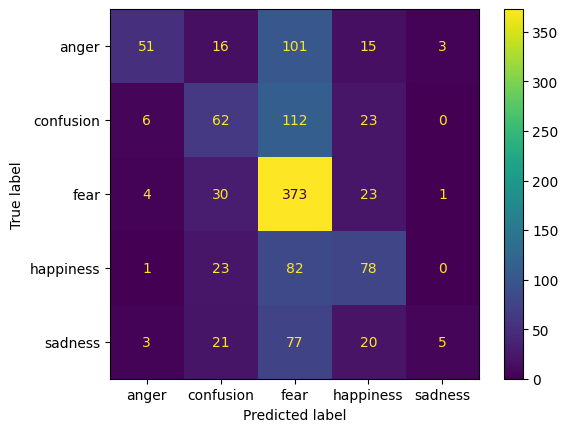

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

## Cross validation
https://scikit-learn.org/stable/modules/cross_validation.html

In [40]:
# Perform cross-validation and print the mean accuracy
scoring = 'f1_macro'
scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

Mean f1_macro: 0.40828471010718187
Standard deviation f1_macro: 0.01451110152051428


# Naive Bayes from scratch

In [102]:
y_train.head()

1040     happiness
25797         fear
16279         fear
1840         anger
26616         fear
Name: emotion, dtype: object

### Calculate priors and vocabulary

In [103]:
from collections import Counter

count_c = Counter(y_train)

priors = {k:v/len(y_train) for k, v in count_c.items()}
print(priors)

train_strings = " ".join(X_train)
train_tokens = word_tokenize(train_strings)
vocabulary = set(train_tokens)
V = len(vocabulary)
classes = set(y_train)

{'happiness': 0.1820796460176991, 'fear': 0.3911504424778761, 'anger': 0.14115044247787611, 'confusion': 0.18871681415929203, 'sadness': 0.09690265486725663}


### Calculate likelihoods 

In [104]:
train_df = pd.DataFrame(zip(X_train, y_train), columns = ["document", "emotion"])
train_df.head()

,document,emotion
0,a man gets out of prison. he's walking around ...,happiness
1,another the agency dream. at first i was outs...,fear
2,"i was at memorial stadium, supposed to do a dj...",fear
3,"i am driving my van, but can't find the keys t...",anger
4,there are four of us and we were trying to ste...,fear


In [113]:
mega_dict = dict()
prob_dict = dict()
k = 1

for c in classes:
    class_df = train_df.query(f"emotion == '{c}'")
    mega_document = class_df["document"]
    mega_strings = " ".join(mega_document)
    mega_tokens = word_tokenize(mega_strings)
    mega_count = Counter(mega_tokens)
    mega_dict[c] = mega_count
    prob_dict[c] = dict()
    

    for token in vocabulary:
        prob_dict[c][token] = (mega_dict[c][token] + k ) / (len(mega_tokens) + V)

print(mega_dict["anger"]["i"])
print(prob_dict["anger"]["i"])

7036
0.04408346854268335


### Prediction

In [114]:
import math

test_tokens = word_tokenize("i don't like it")

pred_dict = dict()

for c in classes:
    sum = math.log2(priors[c])
    for token in test_tokens:
        #print(prob_dict[c][token])
        sum += math.log2(prob_dict[c][token])
    sum = math.pow(2, sum)
    pred_dict[c] = sum
print(pred_dict)
print(max(pred_dict, key=pred_dict.get))

{'anger': 3.8438023650338485e-12, 'happiness': 5.738926582807367e-12, 'confusion': 7.1664344130907345e-12, 'sadness': 2.4003655911873422e-12, 'fear': 2.254136682259967e-11}
fear


In [115]:
import math

test_tokens = [word_tokenize(text) for text in X_test]

pred_dict = dict()
preds = list()

for report_tokens in test_tokens:
    for c in classes:
        sum = math.log2(priors[c])
        for token in report_tokens:
            if token in prob_dict[c]: # remove unknown tokens
                sum += math.log2(prob_dict[c][token])
        sum = math.pow(2, sum)
        pred_dict[c] = sum
    preds.append(max(pred_dict, key=pred_dict.get))

### Evaluation

In [116]:
from sklearn.metrics import classification_report

print(classification_report(preds, list(y_test)))

              precision    recall  f1-score   support

       anger       0.75      0.18      0.30       754
   confusion       0.10      0.53      0.17        38
        fear       0.33      0.54      0.41       262
   happiness       0.21      0.53      0.30        72
     sadness       0.03      1.00      0.06         4

    accuracy                           0.30      1130
   macro avg       0.28      0.56      0.25      1130
weighted avg       0.59      0.30      0.32      1130

